# XGBoost Random Forest Classifier

The first algorithm that we will use is the XGBoost with its random forest classifier. This example uses a random forest version of the XGBoost classifier. This algorithm will be used for each generated feature, namelly:

- Periodograms
- Bayes Similarity
- Hidden Markov Models

All approaches will pass trough the common machine learning pipeline, where we must:

- Normalize the data (if necessary)
- Divide the data between trainning and testing
- Search the hyper parameters
- Cross validate the models
- Analyse the results

## Periodograms

The application using the periodograms is actually pretty simple, now that the data is prepared and all of those preprocessing from last pipeline step is already done. The algorithm became straigh forward. First it is necessary to read the features generated.

In [1]:
import pickle 

file_name = './features/freq_data/freq_data.pkl' 
with open(file_name, 'rb') as file:
    freq_data = pickle.load(file)
freq_data.keys()

dict_keys(['features', 'labels'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [2]:
import numpy as np
from sklearn import preprocessing

# Create the label encoder
le_freq = preprocessing.LabelEncoder()
le_freq.fit(freq_data['labels'])

# Define the regression model
regressors = preprocessing.normalize(freq_data['features']['spec'])
outputs = le_freq.transform(freq_data['labels'])

In [3]:
regressors.shape[1]

12758

Also it is interesting to reduce the features dimension to build a simpler model. It is not necessary to create a classifier with such amount (12758 features...) of features. There are several techniques that can be used to reduce the features dimensions. The Principal Component Analisys, is very effective when dealing with high dimensional data. Here the `PCA` algorithm from the `sklearn` library is used.

In [4]:
from sklearn.decomposition import PCA

# Create the PCA decomposer
pca_dec = PCA(n_components=69, svd_solver='arpack')

# Train the PCA object
pca_dec.fit(regressors)

# Transform the data using
# the PCA model
pca_regressor = pca_dec.transform(regressors)

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    pca_regressor, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `objective` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [6]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

# Define the model parameters 
param_dist = {
    'objective':'binary:logistic', 
    'n_estimators' : 11
}

# Create the range parameters to 
# search
n_estimators = [ k+1 for k in range(100)]

# Create the plotting variable
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}

# Estimate and validate each candidate
for opt in n_estimators:
    # Update the model parameters
    param_dist['n_estimators'] = opt
    # Create the xgBoost classifier
    clfs = xgb.XGBRFClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train,
            eval_metric='logloss',
            verbose=True)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    plot_vals['true']['confirmed targets'].append(conf_mat[0,0])
    plot_vals['true']['eclipsing binaries'].append(conf_mat[1,1])
    plot_vals['false']['confirmed targets'].append(conf_mat[0,1])
    plot_vals['false']['eclipsing binaries'].append(conf_mat[1,0])

In [7]:
from utils import *

# Line plot each confidence matrix parameter
x_data = [n_estimators, n_estimators, n_estimators, n_estimators]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion parameters plot',
                         color_index=colors,
                         y_axis={'label': 'Proportion'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

Loading BokehJS ...

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis. The model is saved on a particular variable, such as `freq_clf` to be further used in some vote chain model, if further necessary. 

> *One interesting result from the above result, is that the best compromise result happens at the $n_x = 5$ not on $n_x=4$ as it seems. Even though for the $n_x=4$ the algorithm is able to get all the exo planets, the compromise on having a confidence of only 66% for the eclipsing binaries classification (classifier close to a coin flipper to classify eclipsing binaries), doesn't allow us to select $n_x=4$. Therefore the best trade-off on both classes happens at $n_x=5$.* 

In [8]:
# XGBoost Classifier model parameters
param_dist = {
    'verbosity': 0,
    'objective':'binary:logistic', 
    'n_estimators' : 4
}

# Create the model classifier
freq_clf = xgb.XGBRFClassifier(**param_dist)

# Train the model
freq_clf.fit(X_train, y_train,
              eval_set=[
                (X_train, y_train), 
                (X_test, y_test)
              ],
              eval_metric='logloss',
              verbose=False)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=4, n_jobs=0, num_parallel_tree=4,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=0)

### Results

In this part it is presented the results from the classification algorithm. Both regarding the data visualization and the model classification quality. 

In [9]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

pp.pprint(freq_clf.evals_result())

{ 'validation_0': {'logloss': [0.296643]},
  'validation_1': {'logloss': [0.695378]}}


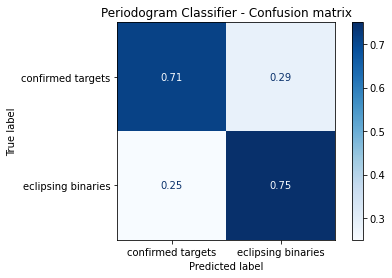

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(freq_clf, X_test, y_test,
                             display_labels=le_freq.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Periodogram Classifier - Confusion matrix')
plt.show()

#### Comments

From this results it is possible to see that the classifier using periodogram amplitudes can get some interesting knowledge on the eclipsing binaries classification, but could not extract any information to classify properly the confirmed targets. It is almost as if the model is blind when an exo planet periodogram is presented as feature to the algorithm. 

## Naive Bayes likelihood

Here we will read the Naive Bayes model parameters estimated for each light curve and use this information as feature for the xgBoost classifier. To start this approach, we must first read the Bayes features saved from last step:

In [11]:
import pickle 

file_name = './features/bayes_data/nx_6/bayes_data.pkl'
with open(file_name, 'rb') as file:
    bayes_data = pickle.load(file)
bayes_data.keys()

dict_keys(['features', 'labels'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [12]:
import numpy as np
from sklearn import preprocessing

# Create the label encoder
le_bayes = preprocessing.LabelEncoder()
le_bayes.fit(bayes_data['labels'])

# Define the regression model
regressors = preprocessing.normalize(bayes_data['features']['params'])
outputs = le_bayes.transform(bayes_data['labels'])

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    regressors, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `objective` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [14]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

# Define the model parameters 
param_dist = {
    'objective':'binary:logistic', 
    'n_estimators' : 11
}

# Create the range parameters to 
# search
n_estimators = [ k+1 for k in range(100)]

# Create the plotting variable
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}

# Estimate and validate each candidate
for opt in n_estimators:
    # Update the model parameters
    param_dist['n_estimators'] = opt
    # Create the xgBoost classifier
    clfs = xgb.XGBRFClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train,
            eval_metric='logloss',
            verbose=True)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    plot_vals['true']['confirmed targets'].append(conf_mat[0,0])
    plot_vals['true']['eclipsing binaries'].append(conf_mat[1,1])
    plot_vals['false']['confirmed targets'].append(conf_mat[0,1])
    plot_vals['false']['eclipsing binaries'].append(conf_mat[1,0])

In [15]:
from utils import *

# Line plot each confidence matrix parameter
x_data = [n_estimators, n_estimators, n_estimators, n_estimators]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion parameters plot',
                         color_index=colors,
                         y_axis={'label': 'Proportion'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis. The model is saved on a particular variable, such as `bayes_clf` to be further used in some vote chain model, if further necessary.

In [16]:
# XGBoost Classifier model parameters
param_dist = {
    'verbosity': 0,
    'objective':'binary:logistic', 
    'n_estimators' : 1
}

# Create the model classifier
bayes_clf = xgb.XGBRFClassifier(**param_dist)

# Train the model
bayes_clf.fit(X_train, y_train,
              eval_set=[
                (X_train, y_train), 
                (X_test, y_test)
              ],
              eval_metric='logloss',
              verbose=False)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=1, n_jobs=0, num_parallel_tree=1,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=0)

### Results

In this part it is presented the results from the classification algorithm. Both regarding the data visualization and the model classification quality. 

In [17]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

pp.pprint(bayes_clf.evals_result())

{ 'validation_0': {'logloss': [0.33231]},
  'validation_1': {'logloss': [0.530174]}}


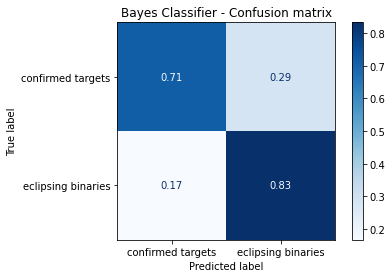

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(bayes_clf, X_test, y_test,
                             display_labels=le_bayes.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Bayes Classifier - Confusion matrix')
plt.show()

#### Comments

From this results it is possible to see that the classifier using Naive Bayes estimated model parameters is able to highly characterize the eclipsing binaries, and has acceptable classification performance for the confirmed targets.

---

## Hidden Markov Models

Here we use the model estimated from the Hidden Markov Models library, wich is the estimated $A$ matrix, or the so called transition probability matrices as feature for the learning classifier. For that we must read the pickle file with the desired features:

In [19]:
import pickle 

file_name = './features/hmm_data/nx_8/hmm_data.pkl'
with open(file_name, 'rb') as file:
    hmm_data = pickle.load(file)
hmm_data.keys()

dict_keys(['y', 't', 'labels', 'features'])

### Manipulate features

After reading the data, it is necessary to create the classical regression structure model in the format $Y = f\left(\Theta, X\right)$, normalize the feature data and encode any possible label data into numerical classes. This is just the preparation for the machine leaning algorithm to guarantee that the provided info is properlly designed for any machine learning classical form.

In [20]:
import numpy as np
from sklearn import preprocessing

# Encode the label
le_hmm = preprocessing.LabelEncoder()
le_hmm.fit( hmm_data['labels'] )

# Define the model order
feat = hmm_data['features']
nx = feat['prob_matrix'][0].shape[0]

regressors = []
for phi in feat['prob_matrix']:
    # Reshape the regressor
    reg = phi.reshape(nx*nx)
    # Add to the regressors
    regressors.append(reg)   
# Normalize the regressors
regressors = preprocessing.normalize(regressors)
# Define outputs as encoded variables
outputs = le_hmm.transform(hmm_data['labels'])

### Train-test data split

Next it is necessary to segregate the data into a set for validation and one for trainning the model.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    regressors, outputs, test_size=0.33, random_state=42)

### Hyper tunning

We could consider tunning the model hyper parameters to answer questions such as:

- Wich value of `n_estimators` is the best for this model and data?
- Wich cost function is the best to be selected as `objective` for this model?

We could do a hyper search, to find the best hyper parameters for this model, automating the hyper parameter selection. There are several already builded algorithms to optimize this parameter search, and build find with high performance the best parameters, provided a set of possible values. But, to understand what those algorithms actually does, we could once build our own search algorithm...

As an example, lets run a first handly defined hyper parameter tunning using the confusion matrix of the model:

In [22]:
from sklearn.metrics import confusion_matrix

n_estimators = [ k+1 for k in range(100)]

conf_matrices = []
for opt in n_estimators:
    # Update the model parameters
    param_dist['n_estimators'] = opt
    # Create the xgBoost classifier
    clfs = xgb.XGBRFClassifier(**param_dist)
    # Fit the model to the data
    clfs.fit(X_train, y_train,
            eval_metric='logloss',
            verbose=True)
    # Estimate the test output
    y_pred = clfs.predict(X_test)
    # Compute the confusion matrix
    conf_mat = confusion_matrix(
        y_test, y_pred,
        normalize='true')
    # Save the confusion matrix
    conf_matrices.append(conf_mat)

In [23]:
from utils import *

# Create and organize the plot values
plot_vals = {
    'true': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    },
    'false': {
        'confirmed targets': [],
        'eclipsing binaries': [],
    }
}
for result in conf_matrices:
    plot_vals['true']['confirmed targets'].append(result[0,0])
    plot_vals['true']['eclipsing binaries'].append(result[1,1])
    plot_vals['false']['confirmed targets'].append(result[0,1])
    plot_vals['false']['eclipsing binaries'].append(result[1,0])

x_values = range(len(conf_matrices))
x_data = [x_values, x_values, x_values, x_values]
y_data = [plot_vals['true']['confirmed targets'],
          plot_vals['true']['eclipsing binaries'],
          plot_vals['false']['confirmed targets'],
          plot_vals['false']['eclipsing binaries']]
legends= ['True - C.T.', 'True - E.B.', 'False - C.T.', 'False - E.B.']
colors = [6, 7, 2, 3]

p = visual.multline_plot(x_data, y_data,
                         legend_label=legends, 
                         title='Hyper parameter search - Confusion plot',
                         color_index=colors,
                         y_axis={'label': 'Intensity'},
                         x_axis={'label': 'n_estimators'})
visual.show_plot(p)

The user might see that the best values for the `n_estimators` parameter is something close to `[4,5,6]`. When we have a range of values, such as here, usually is advisable to use the simpler model, in this case `n_estimators=4`, wich is the value defined before.

> *Notice that the value `n_estimators`$=n_x$ defined in the previous step algorithm. Since the hidden markov model is pretty simple such as the classifier. Therefore is possible that the hidden markov model is underfitted, this means that the markov model is to simple to represent the information from the ligt curve, since there is no redundancy on the model. This is infered by checking that `n_estimators`$=n_x$ is the best solution for this problem.*

### Train model

After running the hyper parameter search we can create a model with the best defined hyper parameters, or setup parameters, and consolidate the model in to the best version for further performance analysis. The model is saved on a particular variable, such as `hmm_clf` to be further used in some vote chain model, if further necessary.

In [24]:
import xgboost as xgb

param_dist = {
    'verbosity': 0,
    'objective':'binary:logistic', 
    'n_estimators' : 5
}

hmm_clf = xgb.XGBRFClassifier(**param_dist)

hmm_clf.fit(X_train, y_train,
            eval_set=[
                (X_train, y_train), 
                (X_test, y_test)
            ],
            eval_metric='logloss',
            verbose=False)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=5, n_jobs=0, num_parallel_tree=5,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=0)

### Results

Here we include some visualization results for the xgBoost algorithm classification. As the first result, we just print the model eval metrics, here the *log loss* of the model, for both the trainning and testing data.

In [25]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

evals_result = hmm_clf.evals_result()
pp.pprint(evals_result)

{ 'validation_0': {'logloss': [0.365735]},
  'validation_1': {'logloss': [0.714561]}}


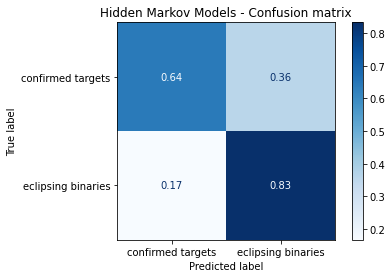

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(hmm_clf, X_test, y_test,
                             display_labels=le_hmm.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Hidden Markov Models - Confusion matrix')
plt.show()